# Machine Learning and the Titanic Data Set
### A generalised approach

We start by importing the necessary libraries.

In [51]:
import numpy as np
import pandas as pd
import itertools as iter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import svm
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import fancyimpute as fi
import missingpy as mpy
import seaborn as sns
import warnings
import re
import math

# ignore depreciation warnings from sklearn
warnings.filterwarnings("ignore", category=DeprecationWarning)

Import csv files to pandas DataFrame.

In [2]:
df_train_set = pd.read_csv('train.csv', header=0, index_col=0)
df_test_set = pd.read_csv('test.csv', header=0, index_col=0)

## Exploratory Data Analysis

On a cursory inspection we find there are missing values in the 'Age', 'Cabin', and 'Embarked' columns, particularly in the 'Cabin' column which may need removing.

In [3]:
df_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Which features correlate with survival and with each other? 

### 1. Pclass

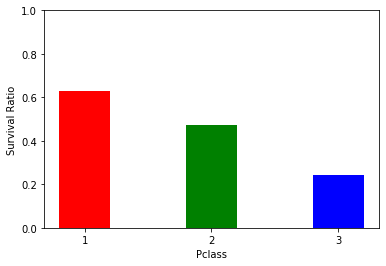

In [4]:
Pclass = df_train_set['Pclass']
Survived = df_train_set['Survived']
Pclass_list = [1, 2, 3]
Pclass_SurvivedRatios = [sum(Survived[Pclass == 1])/sum(Pclass == 1), sum(Survived[Pclass == 2])/sum(Pclass == 2), sum(Survived[Pclass == 3])/sum(Pclass == 3)]

plt.figure(1)
plt.ylabel('Survival Ratio')
plt.xlabel('Pclass')
plt.ylim(0, 1)
plt.xticks(Pclass_list, ['1', '2', '3'])
plt.bar(Pclass_list, Pclass_SurvivedRatios, color=['r', 'g', 'b'], width=0.4)
plt.show()

Plotting Pclass versus the survival ratio we find that Pclass correlates with survival such that a higher Pclass implicates a lower chance of survival. Considering that Pclass is a proxy for socio-economic status this relationship is expected. Higher socio-economic people may have been better situated onboard to acess life boats and recieve help from staff, or may have been more determined to be permitteed onto a lifeboat. For the remainder of this project when refering to people of a higher Pclass we are equivalently refering to people of a lower socio-economic status. 

### 2. Pclass and Sex

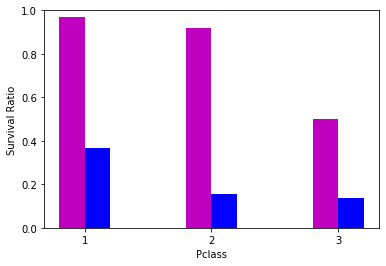

In [5]:
Pclass_list = [1, 2, 3]
female_1 = []
male_1 = []
for pclass in Pclass_list:
    female_1.append(df_train_set[(df_train_set.Sex == 'female') & (df_train_set.Pclass == pclass) &
                               (df_train_set.Survived == 1)].Sex.count() /
                   df_train_set[(df_train_set.Sex == 'female') & (df_train_set.Pclass == pclass)].Sex.count())
    
    male_1.append(df_train_set[(df_train_set.Sex == 'male') & (df_train_set.Pclass == pclass) &
                               (df_train_set.Survived == 1)].Sex.count() /
                   df_train_set[(df_train_set.Sex == 'male') & (df_train_set.Pclass == pclass)].Sex.count())

male_pos = np.array([0., 1., 2.]) + np.array([.1, .1, .1])
female_pos = np.array([0., 1., 2.]) - np.array([.1, .1, .1])

fig2 = plt.figure(2)
ax1 = fig2.add_subplot(1, 1, 1)
ax1.set_ylabel('Survival Ratio')
ax1.set_xlabel('Pclass')
ax1.set_ylim(0, 1)
ax1.set_xticklabels(['1', '2', '3'])
ax1.set_xticks([0, 1, 2])
ax1.bar(male_pos, male_1, color='b', width=0.2, align='center')
ax1.bar(female_pos, female_1, color='m', width=0.2, align='center')
plt.show()

When we group by sex we find that the previous trend of decreaing survival with increasing Pclass holds true for both sexes. For females a notable drop in survivability occurs from Pclass 2 to 3 and for males from Pclass 1 to 2. The distribution of female survival is highly skewed towards survival in the first two Pclasses.

### 3. Embarked, Pclass, and Sex

In exploratory data analysis with discrete features often we need to obtain the counts of certain feature combinations such as, in our case, the total number of females of Pclass 2 who embarked at Queenstown and survived. It would be helpful to have a dataframe with rows of feature combinations and their respective label counts and ratios. The 'label_counts_by_groups' function returns this dataframe.

In [6]:
def get_key(tuple):
    """Gets key for label_counts_by_groups"""

    key = ''
    for val in tuple:
        key = key + '_{}'.format(val)

    return key

def label_counts_by_groups(dataframe, features, label):
    """Groups by features and calculates label count"""

    # dictionary withs features as keys and unique feature values as values
    feature_dict = {}
    for index, feature in enumerate(features):
        feature_dict.update({index: list(dataframe[dataframe[feature].notnull()][feature].unique())})

    # columns for new dataframe
    label_vals = dataframe[label][dataframe[label].notnull()].unique()
    label_vals = list(map(str, label_vals))
    label_count_list = [s + ' count' for s in label_vals]
    label_ratio_list = [v + ' ratio' for v in label_vals]
    columns = features + label_count_list + ['Total Count'] + label_ratio_list

    # calculate data array dimensions and create data with all zeros
    total_values = 1
    for list2 in feature_dict.values():
        total_values = total_values*len(list2)
    data_structure = [[0]*len(columns)]*total_values

    # indexes for new dataframe which are unique and can be used as keys
    index_array = []
    for tuple1 in iter.product(*feature_dict.values()):
        key = ''
        for val2 in tuple1:
            key = key + '_{}'.format(val2)
        index_array.append(key)

    # create new dataframe
    df_out = pd.DataFrame(data=data_structure, index=index_array, columns=columns)

    # fill feature columns
    for key1 in index_array:
        list4 = key1.split('_')
        list4.pop(0)
        df_out.loc[key1, features] = list4

    # fill label count columns
    for row1 in dataframe[features + [label]][dataframe[features + [label]].notnull().all(1)].itertuples(index=False):
        label_val = row1[-1]
        row2 = row1[:-1]
        key2 = get_key(row2)
        new_label = str(label_val) + ' count'
        df_out.loc[key2, new_label] += 1
    df_out['Total Count'] =  df_out[label_count_list].sum(axis=1)
        
    # calculate label ratio columns
    for column in label_ratio_list:
        df_out[column] = df_out[column[0] + ' count'] / df_out['Total Count']
        
    # sort df_out
    df_out = df_out.sort_values(by=features)
    
    return df_out

Consider the features we are currently examining, Pclass, Sex, and Embarked.

In [7]:
label_counts_by_groups(df_train_set, ['Pclass', 'Sex', 'Embarked'], 'Survived')

,Pclass,Sex,Embarked,0 count,1 count,Total Count,0 ratio,1 ratio
_1_female_C,1,female,C,1,42,43,0.023256,0.976744
_1_female_Q,1,female,Q,0,1,1,0.000000,1.000000
_1_female_S,1,female,S,2,46,48,0.041667,0.958333
_1_male_C,1,male,C,25,17,42,0.595238,0.404762
_1_male_Q,1,male,Q,1,0,1,1.000000,0.000000
_1_male_S,1,male,S,51,28,79,0.645570,0.354430
_2_female_C,2,female,C,0,7,7,0.000000,1.000000
_2_female_Q,2,female,Q,0,2,2,0.000000,1.000000
_2_female_S,2,female,S,6,61,67,0.089552,0.910448
_2_male_C,2,male,C,8,2,10,0.800000,0.200000


We can then use label_counts_by_group in our exploration of Pclass, Sex, and Embarkment.

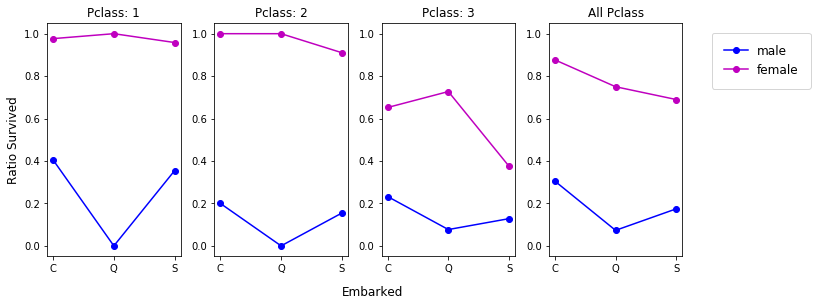

In [9]:
table_1 = label_counts_by_groups(df_train_set, ['Pclass', 'Sex', 'Embarked'], 'Survived')
Pclass_1__male = table_1.loc[(table_1.Pclass == '1') & (table_1.Sex == 'male'), '1 ratio']
Pclass_1__female = table_1.loc[(table_1.Pclass == '1') & (table_1.Sex == 'female'), '1 ratio']
Pclass_2__male = table_1.loc[(table_1.Pclass == '2') & (table_1.Sex == 'male'), '1 ratio']
Pclass_2__female = table_1.loc[(table_1.Pclass == '2') & (table_1.Sex == 'female'), '1 ratio']
Pclass_3__male = table_1.loc[(table_1.Pclass == '3') & (table_1.Sex == 'male'), '1 ratio']
Pclass_3__female = table_1.loc[(table_1.Pclass == '3') & (table_1.Sex == 'female'), '1 ratio']

table_2 = label_counts_by_groups(df_train_set, ['Sex', 'Embarked'], 'Survived')
Pclass_All__male = table_2.loc[table_2.Sex == 'male', '1 ratio']
Pclass_All__female = table_2.loc[table_2.Sex == 'female', '1 ratio']

Embarked_labels = ['C', 'Q', 'S']
label_pos = [0, 1, 2]
plt.figure(num=4, figsize=(12, 4))
fig4 = plt.figure(4)

ax1 = fig4.add_subplot(1, 5, 1)
ax1.set_xticklabels(Embarked_labels)
ax1.set_xticks(label_pos)
ax1.set_ylabel('Ratio Survived', fontsize='large')
ax1.set_ylim(-0.05, 1.05)
ax1.title.set_text('Pclass: 1')
ax1.plot(label_pos, Pclass_1__male, 'b-', marker='o', label='male')
ax1.plot(label_pos, Pclass_1__female, 'm-', marker='o', label='female')

ax2 = fig4.add_subplot(1, 5, 2)
ax2.set_xticklabels(Embarked_labels)
ax2.set_xticks(label_pos)
ax2.set_ylim(-0.05, 1.05)
ax2.title.set_text('Pclass: 2')
ax2.plot(label_pos, Pclass_2__male, 'b-', marker='o', label='male')
ax2.plot(label_pos, Pclass_2__female, 'm-', marker='o', label='female')

ax3 = fig4.add_subplot(1, 5, 3)
ax3.set_xticklabels(Embarked_labels)
ax3.set_xticks(label_pos)
ax3.set_ylim(-0.05, 1.05)
ax3.title.set_text('Pclass: 3')
ax3.plot(label_pos, Pclass_3__male, 'b-', marker='o', label='male')
ax3.plot(label_pos, Pclass_3__female, 'm-', marker='o', label='female')

ax4 = fig4.add_subplot(1, 5, 4)
ax4.set_xticklabels(Embarked_labels)
ax4.set_xticks(label_pos)
ax4.set_ylim(-0.05, 1.05)
ax4.title.set_text('All Pclass')
ax4.plot(label_pos, Pclass_All__male, 'b-', marker='o', label='male')
ax4.plot(label_pos, Pclass_All__female, 'm-', marker='o', label='female')

handles, labels = ax4.get_legend_handles_labels()
fig4.legend(handles, labels, loc=(0.85, 0.71), fontsize='large', borderpad = 1)
fig4.text(x=0.4, y=-0.04, s='Embarked', fontsize='large')


plt.tight_layout()

Both men and women were more likely to have a lower Pclass and survive if they embarked at Cherbourg. The discrepency to which women survived more than men was lowest for those who embarkded at Southampton. Men particularly suffered if they were from Queenstown. Women who embarked at Queenstown appeared to out survive the rest when each Pclass is compared individually, but this is not the case in the overall group. 

This highlights the limiation of the above visualisation. There were only two women of Pclass 2, and one women of Plcass 1, who embarked at Queenscliff. Thus the breakdown by Pclass often reduces the sample size to insignificant numbers which cannnot relay statistically meaningfull information. Likewise, it would seem, men from Queenstown faired better if they were in Pclass 3, however in each of Pclass 1 and 2 there was only one male.

### 4. Age

Let us examine the survival for every whole number age.

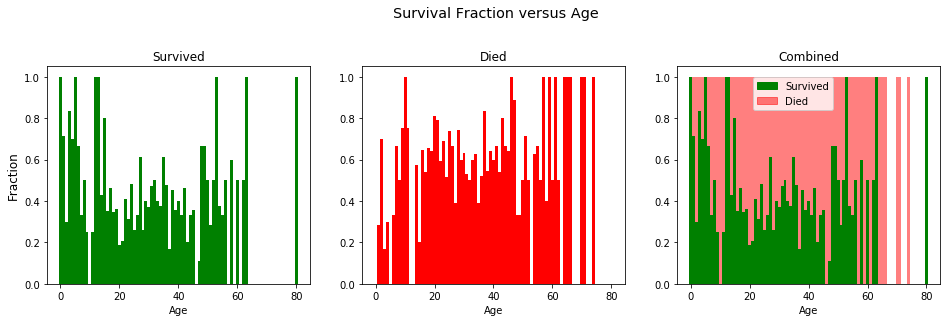

In [92]:
# get series of both non-null ages and survival for those non-null ages
age_notnull = df_train_set['Age'][df_train_set['Age'].notnull()]
survived_age_notnull = Survived[df_train_set['Age'].notnull()]

# calculate counts of binned ages
age_binned = np.floor(age_notnull.values)
max_age = max(age_binned)
count_age_binned = [0]*(int(sum([max_age, 1])))

# get counts those who died and those who survived in binned ages
count_age_survived = count_age_binned.copy()
for val1 in age_binned:
    count_age_binned[int(val1)] += 1
for idx1, val2 in enumerate(survived_age_notnull):
    count_age_survived[int(age_binned[idx1])] += val2
count_age_died = np.subtract(np.array(count_age_binned), np.array(count_age_survived))

# calculate ratios of died and survived binned ages
count_age_binned = np.array(count_age_binned)
np.putmask(count_age_binned, count_age_binned==0, 1)
ratio_age_survived = np.divide(np.array(count_age_survived), np.array(count_age_binned))
ratio_age_died = np.divide(count_age_died, np.array(count_age_binned))

# plot
plt.figure(num=7, figsize=(16, 4))
fig7 = plt.figure(7)
fig7.text(x=0.425, y=1.05, s='Survival Fraction versus Age', fontsize='x-large')

ax1 = fig7.add_subplot(1, 3, 1)
ax1.set_ylim(0, 1.05)
ax1.set_ylabel('Fraction', fontsize='large')
ax1.set_xlabel('Age')
ax1.set_title('Survived')
ax1.bar(list(range(0, 81)), ratio_age_survived, color=['g'], width=1)

ax2 = fig7.add_subplot(1, 3, 2)
ax2.set_ylim(0, 1.05)
ax2.set_title('Died')
ax2.set_xlabel('Age')
ax2.bar(list(range(0, 81)), ratio_age_died, color='r', width=1)

ax3 = fig7.add_subplot(1, 3, 3)
ax3.set_ylim(0, 1.05)
ax3.set_title('Combined')
ax3.set_xlabel('Age')
ax3.bar(list(range(0, 81)), ratio_age_survived, color=['g'], width=1)
ax3.bar(list(range(0, 81)), ratio_age_died, bottom=Ratio_age_survived, color=(1, 0, 0, 0.5), width=1)
red_patch = mpatches.Patch(color=(1, 0, 0, 0.5), label='Died')
green_patch = mpatches.Patch(color='green', label='Survived')
ax3.legend(handles=[green_patch, red_patch], loc=(0.29, 0.8))

plt.show()

The breakdown by age with a bin size of one year gives a detailed picture but it is difficult to make out any trends.

In [245]:
df_age = df_train_set.loc[df_train_set.Age.notnull(), ['Age', 'Survived']]
df_age_groupby = df_age.groupby(pd.cut(df_age['Age'], bins=range(0, 81, 8))).agg({'Age': 'count', 'Survived': 'sum'})
df_age_groupby.columns = ['Total Count', 'Survived Count']
df_age_groupby['Survived Fraction'] = df_age_groupby['Survived Count'] / df_age_groupby['Total Count']
df_age_groupby = df_age_groupby.reset_index()
df_age_groupby

,Age,Total Count,Survived Count,Survived Fraction
0,"(0, 8]",54,36,0.666667
1,"(8, 16]",46,19,0.413043
2,"(16, 24]",177,63,0.355932
3,"(24, 32]",169,65,0.384615
4,"(32, 40]",118,52,0.440678
5,"(40, 48]",70,24,0.342857
6,"(48, 56]",45,21,0.466667
7,"(56, 64]",24,9,0.375000
8,"(64, 72]",9,0,0.000000
9,"(72, 80]",2,1,0.500000


The last two age bins have too low a population count so we need to combined them into a single bin.

In [246]:
df_age_groupby.loc[10] = ['(64, 80]'] + list(df_age_groupby.drop('Age', axis=1).loc[8]
                                             + df_age_groupby.drop('Age', axis=1).loc[9])

bin10_sur_frac = df_age_groupby.loc[[10], 'Survived Count'] / df_age_groupby.loc[[10], 'Total Count']
df_age_groupby.loc[[10], 'Survived Fraction'] = bin10_sur_frac
df_age_groupby = df_age_groupby.drop([8, 9], axis=0)
df_age_groupby

,Age,Total Count,Survived Count,Survived Fraction
0,"(0, 8]",54.0,36.0,0.666667
1,"(8, 16]",46.0,19.0,0.413043
2,"(16, 24]",177.0,63.0,0.355932
3,"(24, 32]",169.0,65.0,0.384615
4,"(32, 40]",118.0,52.0,0.440678
5,"(40, 48]",70.0,24.0,0.342857
6,"(48, 56]",45.0,21.0,0.466667
7,"(56, 64]",24.0,9.0,0.375000
10,"(64, 80]",11.0,1.0,0.090909


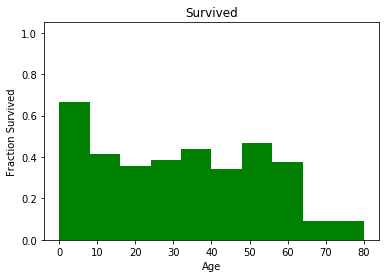

In [261]:
plt.ylim(0, 1.05)
plt.title('Survived')
plt.xlabel('Age')
plt.ylabel('Fraction Survived')
plt.bar(list(range(4, 61, 8)) + [72], df_age_groupby['Survived Fraction'].values, color='g', width=([8]*8 + [16]))
plt.show()

One was most likely to survive if they were a child and least likely to survive if the were elderly. From around the years of 15 to 65 the survival rate is fairly even with some variation about 0.4. This is not too suprising, likely the adults prioritised saving the young and the elderly were at a large physical disadvantage.

A significant portion of our age data is missing. To determine whether our data is missing completely at random (MCAR), missing at random (MAR), or missing not at random (MNAR) we compare the features of the missing data against those of the present data.

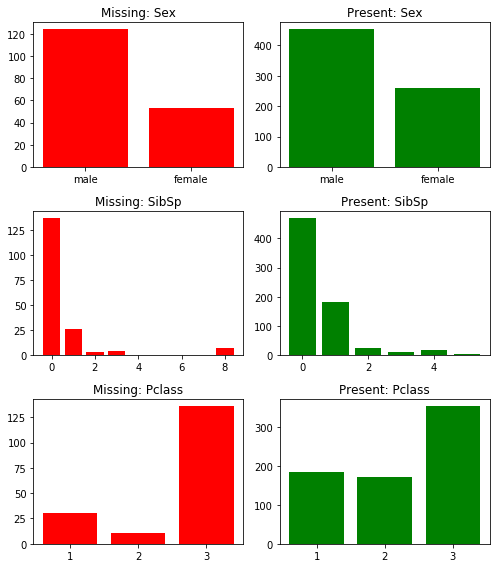

In [22]:
df_age_missing = df_train_set[~df_train_set.Age.notnull()]
df_age_present = df_train_set[df_train_set.Age.notnull()]

sex_miss_vals = df_age_missing['Sex'].value_counts().values
sex_miss_pos = df_age_missing['Sex'].value_counts().index
sex_pres_vals = df_age_present['Sex'].value_counts().values
sex_pres_pos = df_age_present['Sex'].value_counts().index

sibsp_miss_vals = df_age_missing['SibSp'].value_counts().values
sibsp_miss_pos = df_age_missing['SibSp'].value_counts().index
sibsp_pres_vals = df_age_present['SibSp'].value_counts().values
sibsp_pres_pos = df_age_present['SibSp'].value_counts().index

pclass_miss_vals = df_age_missing['Pclass'].value_counts().values
pclass_miss_pos = df_age_missing['Pclass'].value_counts().index
pclass_pres_vals = df_age_present['Pclass'].value_counts().values
pclass_pres_pos = df_age_present['Pclass'].value_counts().index

plt.figure(num=9, figsize=(7, 8))
fig9 = plt.figure(9)

sex_labels = ['Male', 'Female']
ax1 = fig9.add_subplot(3, 2, 1)
ax1.set_xticks([1, 2], sex_labels)
ax1.title.set_text('Missing: Sex')
ax1.bar(sex_miss_pos, sex_miss_vals, color='r')
ax2 = fig9.add_subplot(3, 2, 2)
ax2.set_xticks([1, 2], sex_labels)
ax2.title.set_text('Present: Sex')
ax2.bar(sex_pres_pos, sex_pres_vals, color='g')

sibsp_labels = range(9)
ax3 = fig9.add_subplot(3, 2, 3)
ax3.title.set_text('Missing: SibSp')
ax3.bar(sibsp_miss_pos, sibsp_miss_vals, color='r')
ax4 = fig9.add_subplot(3, 2, 4)
ax4.title.set_text('Present: SibSp')
ax4.bar(sibsp_pres_pos, sibsp_pres_vals, color='g')

pclass_labels = ['Pclass 1', 'Pclass 2', 'Pclass 3']
ax5 = fig9.add_subplot(3, 2, 5)
ax5.title.set_text('Missing: Pclass')
ax5.set_xticks([1, 2, 3], pclass_labels)
ax5.bar(pclass_miss_pos, pclass_miss_vals, color='r')
ax6 = fig9.add_subplot(3, 2, 6)
ax6.title.set_text('Present: Pclass')
ax6.set_xticks([1, 2, 3], pclass_labels)
ax6.bar(pclass_pres_pos, pclass_pres_vals, color='g')

plt.tight_layout()
plt.show()

The feature distributions for both 'Sex' and 'SibSp' are similiar across both data sets. There may be a slight tendency for male age data to be missing over female age data. With respect to the 'Pclass' feature it is the case that those with a lower Pclass (higher socio-economic status) are unlikely to have missing data. Considering both a lower pclass and female sex correlate with survival it is a reasonable hypothesis the causal agent is survival. That is to say those who did not survive were more likely to have missing data.

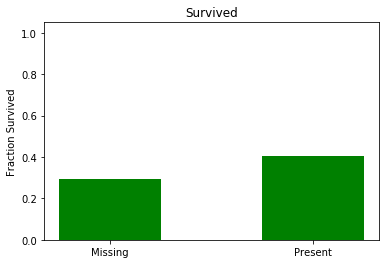

In [274]:
miss_surv_ratio = df_age_missing.Survived.sum() / df_age_missing.Survived.count()
pres_surv_ratio = df_age_present.Survived.sum() / df_age_present.Survived.count()

plt.ylim(0, 1.05)
plt.title('Survived')
plt.ylabel('Fraction Survived')
plt.xticks([0, 1], ['Missing', 'Present'])
plt.bar(['Missing', 'Present'], [miss_surv_ratio, pres_surv_ratio], color='g', width=0.5)
plt.show()

The missing data has a lower survival ratio than the present data by about 0.1. It is a reasonable assumption the missingness of our age data depends on the other features. This allows us to classify the missingness as missing at randon, which has important implications for future data imputation. 

### 5. Fare

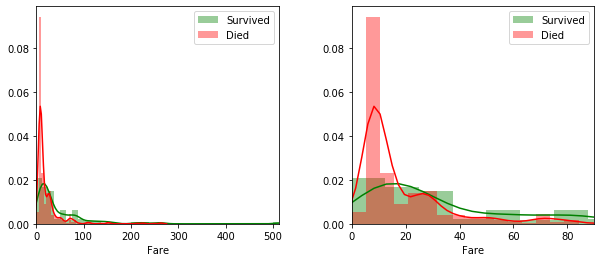

In [13]:
fig11 = plt.figure(11, figsize=(10, 4))
fig11.subplots_adjust(wspace=0.3)
axs = [fig11.add_subplot(1,2,1), fig11.add_subplot(1,2,2)]
sns.distplot(a=df_train_set.Fare[df_train_set.Survived == 1], kde=True, color='g', ax=axs[0], label='Survived')
sns.distplot(a=df_train_set.Fare[df_train_set.Survived == 0], kde=True, color='r', ax=axs[0], label='Died')
sns.distplot(a=df_train_set.Fare[df_train_set.Survived == 1], kde=True, color='g', ax=axs[1], label='Survived')
sns.distplot(a=df_train_set.Fare[df_train_set.Survived == 0], kde=True, color='r', ax=axs[1], label='Died')
for ax in axs: ax.legend()
axs[0].set_xlim(0, max(df_train_set.Fare))
axs[1].set_xlim(0, 90)

plt.show()

The bulk of the fare prices lie within a range from 0 to 40. How come there are a few very large fare prices? These large fares represent the total price of a group booking. Theoretically every fare is a group fare of at least one person. The 'Fare' feature is really a group booking price feature.

It seems that any very expensive booking group also survived. Although difficult to see, this is indicated by the leftmost figure, the red line ends somewhere around 280. Let us examine those with group fare prices above 300.

In [14]:
df_train_set.loc[df_train_set.Fare > 300]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


There is only one group with a fare price of over 300 and they all survived. They were also in the lowest Pclass or highest socio-economic category. This is potentially evidence of a group survival phenomenon.

## Data Prepocessing and Feature Engineering

We combine both the training and test set for easier manipulation of the data, making sure to include an identifier for which data set a given record originated from.

In [15]:
df_train_set['Train'] = 1
df_test_set['Train'] = 0
df_combined = pd.concat([df_train_set, df_test_set], sort=True)

### 1. Women Child Groups

We touched on a possible group survival phenomenon briefly with the 'Fare' feature. Consider engineering a family feature. How well will this feature predict survival? To create a family we can utilise the features, 'Name', 'SipSb', 'Parch', 'Embarked', 'Ticket', 'Pclass', and 'Fare'. We can then create a unique identifier from these features, say family id. We must be careful to identify features which vary within a given family or have mistakes. As we will see shortly this is the case for Ticket, SipSp, and Parch.

In [16]:
surname_list = []
ticket_list = []
for index, row in df_combined.iterrows():
    
    #surname
    regex_object_surname = re.compile('^[^,]*')
    match_object_surname = regex_object_surname.search(row.Name)
    surname = match_object_surname.group(0)
    surname_list.append(surname)
    
    #ticket
    regex_object_ticket = re.compile('[^ ]*$')
    match_object_ticket = regex_object_ticket.search(row.Ticket)
    ticket = match_object_ticket.group(0)
    ticket_list.append(ticket)
    
df_surname_ticket = pd.DataFrame(np.transpose([surname_list, ticket_list]), columns=['Surname', 'Ticket'])
sr_surname_groupby = df_surname_ticket.groupby('Surname').apply( lambda x: x['Ticket'].unique())
sr_surname_groupby[0:17]

Surname
Abbing                     [5547]
Abbott                     [2673]
Abelseth         [348122, 348125]
Abelson                    [3381]
Abrahamsson             [3101284]
Abrahim                    [2657]
Adahl                      [7076]
Adams                    [341826]
Ahlin                      [7546]
Aks                      [392091]
Albimona                   [2699]
Aldworth                 [248744]
Alexander                  [3474]
Alhomaki                [3101287]
Ali            [3101311, 3101312]
Allen             [373450, 24160]
Allison                  [113781]
dtype: object

One can see with the Abelseth, Ali, and Allen families the tickit number varies amoungst its members. As for the Allen family it is aparent that the two ticket numbers represent two unrelated individuals which is in contrast with the other two offenders of whom only the last digit varies. It is the case that occasionally the last digit of a ticket number varies amoungst families. To remedy this we can change the last digit of all ticket numbers to a constant symbol, say'X', or merely drop it. When the varying ticket numbers represent two different parties the inclusion of the surname number as well as other features within the family id will seperate the two parties.

In [17]:
print(df_combined[df_combined.Name.str.contains('Watt')][['Name', 'Ticket', 'Embarked',
                                                          'Pclass','SibSp', 'Parch', 'Age']])

                                                          Name      Ticket  \
PassengerId                                                                  
162          Watt, Mrs. James (Elizabeth "Bessie" Inglis Mi...  C.A. 33595   
1012                                      Watt, Miss. Bertha J  C.A. 33595   

            Embarked  Pclass  SibSp  Parch   Age  
PassengerId                                       
162                S       2      0      0  40.0  
1012               S       2      0      0  12.0  


Here all features point to the familial relationship of James Watt and Bertha Watt. Presumably they are Father and Daughter however the Parch feature is 0. Other similar errors exist within both the SipSp and Parch feature and as such we shall refrain from implementing them in our famild id.

In [18]:
family_list = []
for index, row in df_combined.iterrows():
    
    #surname
    regex_object_surname = re.compile('^[^,]*')
    match_object_surname = regex_object_surname.search(row.Name)
    surname = match_object_surname.group(0)
    
    #ticket
    regex_object_ticket = re.compile('[^ ]*$')
    match_object_ticket = regex_object_ticket.search(row.Ticket)
    ticket = match_object_ticket.group(0)[:-1]
    
    #other features
    fare = str(row.Fare)
    embarked = str(row.Embarked)
    pclass = str(row.Pclass)
    
    family_id = '{}_{}_{}_{}_{}'.format(surname, ticket, fare, embarked, pclass)
    family_list.append(family_id)

df_combined['Family_id'] = family_list

In [19]:
print(df_combined[['Family_id', 'SibSp', 'Parch']].sort_values('Family_id')[0:10])

                                Family_id  SibSp  Parch
PassengerId                                            
846                   Abbing_554_7.55_S_3      0      0
1284                 Abbott_267_20.25_S_3      0      2
747                  Abbott_267_20.25_S_3      1      1
280                  Abbott_267_20.25_S_3      1      1
949               Abelseth_34812_7.65_S_3      0      0
1237              Abelseth_34812_7.65_S_3      0      0
875                  Abelson_338_24.0_C_2      1      0
309                  Abelson_338_24.0_C_2      1      0
1143         Abrahamsson_310128_7.925_S_3      0      0
900                Abrahim_265_7.2292_C_3      0      0


Now that we have a family id column to identify families we shall examine the nature of family survival. Let us add a column which identifies for a given individual their position within the family as one of either, a female adult, a male adult, or a child.

In [20]:
df_family = df_combined[['Family_id', 'Sex', 'Age', 'Survived']][df_combined['Family_id'].duplicated(keep=False)]
df_family.Survived.fillna(value=2, inplace=True)

def label_par_ch (row):
    if row.Sex == 'female' and row.Age >= 16 :
        return 'Female_Adult'
    if row.Sex == 'male' and row.Age >= 16 :
        return 'Male_Adult'
    if row.Age < 16 :
        return 'Child'
    else :
        return 'Unknown'
    
df_family['Parent_Child'] = df_combined.apply(lambda row: label_par_ch(row), axis=1)
df_family.sort_values('Family_id')[0:11]

,Family_id,Sex,Age,Survived,Parent_Child
PassengerId,,,,,
280,Abbott_267_20.25_S_3,female,35.00,1.0,Female_Adult
747,Abbott_267_20.25_S_3,male,16.00,0.0,Male_Adult
1284,Abbott_267_20.25_S_3,male,13.00,2.0,Child
1237,Abelseth_34812_7.65_S_3,female,16.00,2.0,Female_Adult
949,Abelseth_34812_7.65_S_3,male,25.00,2.0,Male_Adult
309,Abelson_338_24.0_C_2,male,30.00,0.0,Male_Adult
875,Abelson_338_24.0_C_2,female,28.00,1.0,Female_Adult
856,Aks_39209_9.35_S_3,female,18.00,1.0,Female_Adult
1199,Aks_39209_9.35_S_3,male,0.83,2.0,Child


One more futher qualification for a family is the presence of at least one child.

In [21]:
list_child = df_family.Family_id[df_family.Parent_Child == 'Child'].values
df_family = df_family[df_family.Family_id.isin(list_child)].sort_values('Family_id')
df_family[0:15]

,Family_id,Sex,Age,Survived,Parent_Child
PassengerId,,,,,
747,Abbott_267_20.25_S_3,male,16.00,0.0,Male_Adult
1284,Abbott_267_20.25_S_3,male,13.00,2.0,Child
280,Abbott_267_20.25_S_3,female,35.00,1.0,Female_Adult
1199,Aks_39209_9.35_S_3,male,0.83,2.0,Child
856,Aks_39209_9.35_S_3,female,18.00,1.0,Female_Adult
298,Allison_11378_151.55_S_1,female,2.00,0.0,Child
499,Allison_11378_151.55_S_1,female,25.00,0.0,Female_Adult
306,Allison_11378_151.55_S_1,male,0.92,1.0,Child
1198,Allison_11378_151.55_S_1,male,30.00,2.0,Male_Adult


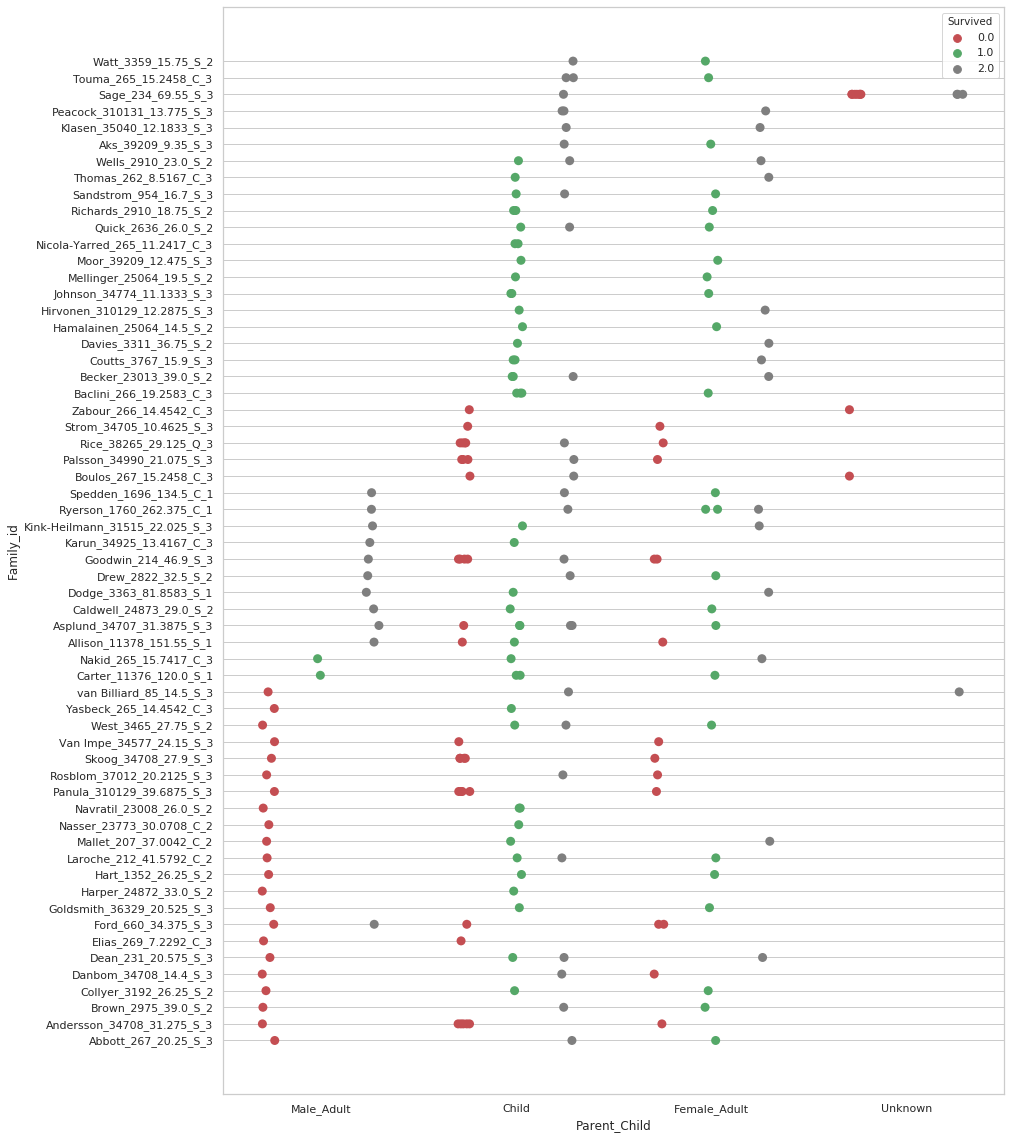

In [22]:
sns.set(style='whitegrid', rc={'figure.figsize':(14, 20)})
sns.stripplot(data=df_family, x='Parent_Child', y='Family_id', hue='Survived', size=9, orient='v',
              jitter=1, palette={0.0: 'r', 1.0: 'g', 2.0: 'tab:gray'}, dodge=True)
plt.show()

Having sorted first by the Male_Adult category it is clear almost all male adults die. With this our feature should predict all adult males die. Thus we now want to drop the adult males from further participation in this feature.

Even though those males who do live come from a family where all the remaining members live there are also instances where every other family member lives and the male adult dies. Additionally by no means does a male adult's death implicates the death of the others. Thus we can not determine the fate of the male adult from the fate of the group and the fate of the group seems unperturbed by the death of the male adult. 

Those members whose familial position is unknown were apart of families who died. So there is likely some causality between the absence of age data and ones family having perished. 

We also want to remove those families for whom all members are in the testing set since we do not know if any of them survived or not.

In [23]:
list_families = ['Klasen_35040_12.1833_S_3', 'van Billiard_85_14.5_S_3', 'Peacock_310131_13.775_S_3']
list_remove = np.logical_or(df_family.Parent_Child == 'Male_Adult', df_family.Family_id.isin(list_families).values)
df_family2 = df_family[~list_remove].copy()
df_family2[0:10]

,Family_id,Sex,Age,Survived,Parent_Child
PassengerId,,,,,
1284,Abbott_267_20.25_S_3,male,13.00,2.0,Child
280,Abbott_267_20.25_S_3,female,35.00,1.0,Female_Adult
1199,Aks_39209_9.35_S_3,male,0.83,2.0,Child
856,Aks_39209_9.35_S_3,female,18.00,1.0,Female_Adult
298,Allison_11378_151.55_S_1,female,2.00,0.0,Child
499,Allison_11378_151.55_S_1,female,25.00,0.0,Female_Adult
306,Allison_11378_151.55_S_1,male,0.92,1.0,Child
542,Andersson_34708_31.275_S_3,female,9.00,0.0,Child
120,Andersson_34708_31.275_S_3,female,2.00,0.0,Child


The van Billiard family had only a male adult in the training set so they are included in our exclusion.

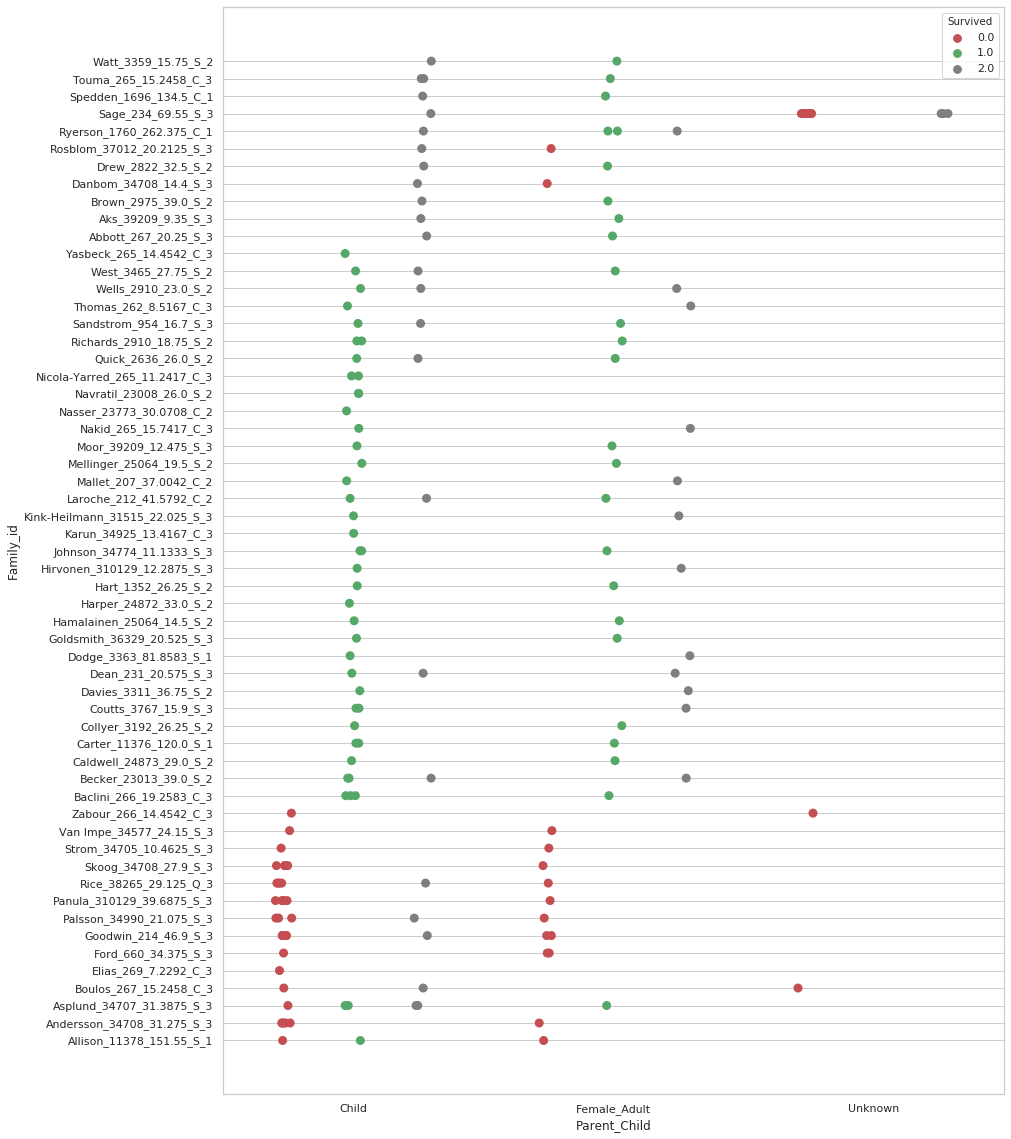

In [24]:
sns.set(style='whitegrid', rc={'figure.figsize':(14, 20)})
sns.stripplot(data=df_family2, x='Parent_Child', y='Family_id', hue='Survived', size=9, orient='v',
              jitter=1, palette={0.0: 'r', 1.0: 'g', 2.0: 'tab:gray'}, dodge=True)
plt.show()

Thus we stubble upon the 'Women Child Groups' feature alluded to at the beginning of the subsection. It is incredible the constistancy with which all members of a women child group either live or die; there are only two instances to the contrary. Let us consider the survival of a women child group member given the average fate of the group.

In [25]:
df_family_survival = df_family2[['Family_id', 'Survived']][~(df_family2.Survived == 2)].groupby(['Family_id']).mean()
df_family_survival[0:10]

,Survived
Family_id,
Abbott_267_20.25_S_3,1.000000
Aks_39209_9.35_S_3,1.000000
Allison_11378_151.55_S_1,0.333333
Andersson_34708_31.275_S_3,0.000000
Asplund_34707_31.3875_S_3,0.750000
Baclini_266_19.2583_C_3,1.000000
Becker_23013_39.0_S_2,1.000000
Boulos_267_15.2458_C_3,0.000000
Brown_2975_39.0_S_2,1.000000


In the dataframe 'df_family_survival' each group is paried with a survival rate. Now we itterate over 'df_family2' to assign each individual family member a corresponding survival prediction based on that rate.

In [26]:
def family_survival(row):
    try:
        fam_pred = round(df_family_survival.loc[row.Family_id], 0)
    except:
        fam_pred = 'NA'
    return fam_pred

df_family2['Pred_Survived'] = df_family2.apply(family_survival, axis=1)
df_family2[0:10]

,Family_id,Sex,Age,Survived,Parent_Child,Pred_Survived
PassengerId,,,,,,
1284,Abbott_267_20.25_S_3,male,13.00,2.0,Child,1.0
280,Abbott_267_20.25_S_3,female,35.00,1.0,Female_Adult,1.0
1199,Aks_39209_9.35_S_3,male,0.83,2.0,Child,1.0
856,Aks_39209_9.35_S_3,female,18.00,1.0,Female_Adult,1.0
298,Allison_11378_151.55_S_1,female,2.00,0.0,Child,0.0
499,Allison_11378_151.55_S_1,female,25.00,0.0,Female_Adult,0.0
306,Allison_11378_151.55_S_1,male,0.92,1.0,Child,0.0
542,Andersson_34708_31.275_S_3,female,9.00,0.0,Child,0.0
120,Andersson_34708_31.275_S_3,female,2.00,0.0,Child,0.0


For those individuals of which we do have survival data ('Survived' $\neq$ 2) we can compare our prediction.

In [27]:
sum(df_family2.Survived == df_family2.Pred_Survived) / sum(~(df_family2.Survived == 2))

0.9838709677419355

This is a great result. The average survival of a women child group predicts the surival of all members with 98% accuracy. What remains is to add this feature to 'df_combined'. We can assign a value of 2 to those of whom this feature does not apply.

In [28]:
def wcg(index):
    try:
        wcg_value = df_family2.Pred_Survived.loc[index]
    except:
        wcg_value = 2
        
    return wcg_value
        
list_wcg = []
for index, row in df_combined.iterrows():
    list_wcg.append(wcg(index))

df_combined['WCG'] = list_wcg
df_combined[0:5]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Train,Family_id,WCG
PassengerId,,,,,,,,,,,,,,
1,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171,1,Braund_2117_7.25_S_3,2.0
2,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599,1,Cumings_1759_71.2833_C_1,2.0
3,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282,1,Heikkinen_310128_7.925_S_3,2.0
4,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803,1,Futrelle_11380_53.1_S_1,2.0
5,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,373450,1,Allen_37345_8.05_S_3,2.0


What about the adult males? We already assertained our feature should predict their death.

In [29]:
df_family3 = df_family.loc[df_family.Parent_Child == 'Male_Adult']
list_index_1 = []
for index in df_family3.index.values:
    df_combined.loc[index, 'WCG'] = 0
    list_index_1.append(index)
    
df_combined.loc[list_index_1][0:5]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Train,Family_id,WCG
PassengerId,,,,,,,,,,,,,,
747,16.0,NaN,S,20.2500,"Abbott, Mr. Rossmore Edward",1,3,male,1,0.0,C.A. 2673,1,Abbott_267_20.25_S_3,0.0
1198,30.0,C22 C26,S,151.5500,"Allison, Mr. Hudson Joshua Creighton",2,1,male,1,NaN,113781,0,Allison_11378_151.55_S_1,0.0
14,39.0,NaN,S,31.2750,"Andersson, Mr. Anders Johan",5,3,male,1,0.0,347082,1,Andersson_34708_31.275_S_3,0.0
1066,40.0,NaN,S,31.3875,"Asplund, Mr. Carl Oscar Vilhelm Gustafsson",5,3,male,1,NaN,347077,0,Asplund_34707_31.3875_S_3,0.0
685,60.0,NaN,S,39.0000,"Brown, Mr. Thomas William Solomon",1,2,male,1,0.0,29750,1,Brown_2975_39.0_S_2,0.0


### 2. Name

If we extract only the titles from the name feature we preserve much of the information, such as ones sex and marital status, while reducing it to a workable categorical feature.

In [30]:
#Feature: Name
df_combined.Name.str.extract('([^\s]*\\.)', expand=False).unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Don.', 'Rev.', 'Dr.', 'Mme.',
       'Ms.', 'Major.', 'Lady.', 'Sir.', 'Mlle.', 'Col.', 'Capt.',
       'Countess.', 'Jonkheer.', 'Dona.'], dtype=object)

Categorising the titles we have that Col., Capt., and Major. are military titles. Lady., Countess., Sir., and Jonkheer. are titles of nobility or honor. As for Mlle. and Mme. they are French for their english counterparts Miss. and Mrs. We can group both Dr. and Rev. as academic titles, although there is an argument to be made to seperate them as a Reverend is both pastoral and academic, we do not want to bloat our feature count any further. Ms. does not distinguish marital stuatus and there is only one person with the title so let us group it in with unmarried women. Dona. is a title given as a mark of recpect. Don. could be an academic title or an honorable title like Dona. and requires further investigation.

In [31]:
df_combined.Name[df_combined.Name.str.match('.*Don\\..*')]

PassengerId
31    Uruchurtu, Don. Manuel E
Name: Name, dtype: object

Researching Don. Manuel E Uruchurtu we find that he was a Mexican man of prominence and as such recieved the title Don. as a mark of respect. This puts him within the noble grouping. 

In [32]:
name_regex_dict = {'.*Mr\\..*': 0, '.*Mrs\\..*': 1, '.*Mme\\..*': 1, '.*Miss\\..*': 2, '.*Ms\\..*': 2,
                   '.*Mlle\\..*': 2, '.*Master\\..*': 3, '.*Rev\\..*': 4, '.*Dr\\..*': 4,
                   '.*Major\\..*': 5, '.*Capt\\..*': 5, '.*Col\\..*': 5, '.*Countess\\..*': 6,
                   '.*Jonkheer\\..*': 6, '.*Don\\..*': 6, '.*Dona\\..*': 6, '.*Lady\\..*': 6, '.*Sir\\..*': 6}

df_combined = df_combined.replace(to_replace=None, regex={'Name': name_regex_dict})

All values in the 'Name' feature have all been mapped to a number.

In [33]:
def is_number(s):
    """Returns True if s is a number and False otherwise"""
    
    try:
        float(s)
        return True
    except ValueError:
        return False

sum(~df_combined.apply(lambda row: is_number(row.Name), axis=1))


0

In [34]:
df_combined[0:5]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Train,Family_id,WCG
PassengerId,,,,,,,,,,,,,,
1,22.0,NaN,S,7.2500,0,0,3,male,1,0.0,A/5 21171,1,Braund_2117_7.25_S_3,2.0
2,38.0,C85,C,71.2833,1,0,1,female,1,1.0,PC 17599,1,Cumings_1759_71.2833_C_1,2.0
3,26.0,NaN,S,7.9250,2,0,3,female,0,1.0,STON/O2. 3101282,1,Heikkinen_310128_7.925_S_3,2.0
4,35.0,C123,S,53.1000,1,0,1,female,1,1.0,113803,1,Futrelle_11380_53.1_S_1,2.0
5,35.0,NaN,S,8.0500,0,0,3,male,0,0.0,373450,1,Allen_37345_8.05_S_3,2.0


### 3. Fare Per Person

Only one person has a missing fare value and that is Mr. Thomas Storey. He is in Pclass 3 which suggests his fare would have been quite cheap. We can fill this value with the mode of 'Fare' which will be a low fare.

In [35]:
df_combined.loc[[1044], 'Fare'] = df_combined['Fare'].mode().values
df_combined.loc[[1044]]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Train,Family_id,WCG
PassengerId,,,,,,,,,,,,,,
1044,60.5,NaN,S,8.05,0,0,3,male,0,NaN,3701,0,Storey_370_nan_S_3,2.0


Since the 'Fare' feature actually represents a group fare it makes sense to break it down into a new feature containing the fare per person. Each fare group is specified by an identical ticket number. Let us create a new dataframe with the fare group sizes.

In [36]:
df_fare_group = df_combined.groupby('Ticket').size()
df_fare_group.head(5)

Ticket
110152    3
110413    3
110465    2
110469    1
110489    1
dtype: int64

Calculate the fare per person with the 'apply' method and 'df_fare_group'.

In [37]:
def fare_group(row):
    fare_value = np.divide(row.Fare, df_fare_group.loc[row.Ticket])
    return fare_value
        
df_combined['Fare_Per_Person'] = df_combined.apply(fare_group, axis=1)
df_combined.sort_values('Ticket')[0:5]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Train,Family_id,WCG,Fare_Per_Person
PassengerId,,,,,,,,,,,,,,,
505,16.0,B79,S,86.50,2,0,1,female,0,1.0,110152,1,Maioni_11015_86.5_S_1,2.0,28.833333
258,30.0,B77,S,86.50,2,0,1,female,0,1.0,110152,1,Cherry_11015_86.5_S_1,2.0,28.833333
760,33.0,B77,S,86.50,6,0,1,female,0,1.0,110152,1,Rothes_11015_86.5_S_1,2.0,28.833333
586,18.0,E68,S,79.65,2,2,1,female,0,1.0,110413,1,Taussig_11041_79.65_S_1,2.0,26.550000
263,52.0,E67,S,79.65,0,1,1,male,1,0.0,110413,1,Taussig_11041_79.65_S_1,2.0,26.550000


### 4. Ticket, SipSp, Parch, Fare, and Sex

Now that we are done engineering features we can remove those features which have little to say about survival on their own. It is clear for the'Cabin' and 'Ticket' features that they do not correlate with survival. 'Cabin' has more data missing than present and 'Ticket' has hundreds of unique values. The information 'SibSp' and 'Parch' contribute is inferior with that of our new 'WCG' feature, likewise for 'Fare' relative to 'Fare_Per_Person'. We can remove all of them and map 'Sex' to 0 and 1.

In [38]:
#Feature: Sex
df_combined = df_combined.replace({'Sex': {'male': 0, 'female': 1}})


#Drop useless features
df_combined = df_combined.drop(['Ticket', 'SibSp', 'Parch', 'Fare', 'Cabin'], axis=1)


df_combined[0:5]

,Age,Embarked,Name,Pclass,Sex,Survived,Train,Family_id,WCG,Fare_Per_Person
PassengerId,,,,,,,,,,
1,22.0,S,0,3,0,0.0,1,Braund_2117_7.25_S_3,2.0,7.25000
2,38.0,C,1,1,1,1.0,1,Cumings_1759_71.2833_C_1,2.0,35.64165
3,26.0,S,2,3,1,1.0,1,Heikkinen_310128_7.925_S_3,2.0,7.92500
4,35.0,S,1,1,1,1.0,1,Futrelle_11380_53.1_S_1,2.0,26.55000
5,35.0,S,0,3,0,0.0,1,Allen_37345_8.05_S_3,2.0,8.05000


### 5. Embarked

In [39]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 10 columns):
Age                1046 non-null float64
Embarked           1307 non-null object
Name               1309 non-null int64
Pclass             1309 non-null int64
Sex                1309 non-null int64
Survived           891 non-null float64
Train              1309 non-null int64
Family_id          1309 non-null object
WCG                1309 non-null float64
Fare_Per_Person    1309 non-null float64
dtypes: float64(4), int64(4), object(2)
memory usage: 112.5+ KB


Both 'Age' and 'Embarked' still have missing data. However there are only two missing embarkment values. This makes it considerably easier to deal with than 'Age'. We can potentially recover all the missing data in this case.

In [40]:
df_train_set.loc[~df_train_set.Embarked.isin(['C', 'S', 'Q'])]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Train
PassengerId,,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1


Notice they both have the same ticket number, thus the two form a booking group. Researching Miss. Amelie Icard shows she traveled along with Mrs. George Stone as her maid, and they both boarded at Southampton. Now we can update their Embarked and Family_id features with the new information.

In [41]:
df_combined.loc[[62, 830], 'Embarked'] = 'S'
df_combined.loc[62, 'Family_id'] = 'Icard_11357_80.0_S_1'
df_combined.loc[830, 'Family_id'] = 'Stone_11357_80.0_S_1'
df_combined.loc[[62, 830]]

,Age,Embarked,Name,Pclass,Sex,Survived,Train,Family_id,WCG,Fare_Per_Person
PassengerId,,,,,,,,,,
62,38.0,S,2,1,1,1.0,1,Icard_11357_80.0_S_1,2.0,40.0
830,62.0,S,1,1,1,1.0,1,Stone_11357_80.0_S_1,2.0,40.0


Finally we convert the embarked values to integers.

In [42]:
df_combined = df_combined.replace({'Embarked': {'C': 0, 'S': 1, 'Q': 2}})

### 6. One Hot Encoding

We give our machine learning algorithims a better opportunity to interpret categorical data by mapping each category in each feature to a new binary feature. This is called one hot encoding and we can do it before data imputaion depending on the imputation method used.

In [43]:
df_combined_dummies = pd.get_dummies(data=df_combined, columns=['Embarked', 'Name', 'Pclass', 'WCG'])
df_combined_dummies[0:5]

,Age,Sex,Survived,Train,Family_id,Fare_Per_Person,Embarked_0,Embarked_1,Embarked_2,Name_0,...,Name_3,Name_4,Name_5,Name_6,Pclass_1,Pclass_2,Pclass_3,WCG_0.0,WCG_1.0,WCG_2.0
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,22.0,0,0.0,1,Braund_2117_7.25_S_3,7.25000,0,1,0,1,...,0,0,0,0,0,0,1,0,0,1
2,38.0,1,1.0,1,Cumings_1759_71.2833_C_1,35.64165,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,26.0,1,1.0,1,Heikkinen_310128_7.925_S_3,7.92500,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
4,35.0,1,1.0,1,Futrelle_11380_53.1_S_1,26.55000,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
5,35.0,0,0.0,1,Allen_37345_8.05_S_3,8.05000,0,1,0,1,...,0,0,0,0,0,0,1,0,0,1


### 7. Age

We have approximately 20% of our age data is missing. There are several imputation methods applicable here such as mean/mode filling, multiple imputation by chained equations (MICE), or sampling from a random distribution. It is not expected that age will play a very large role in survival prediction as it does not corrrelate strongly with survivial. We need to avoid overfitting with our 'Age' feature and avoid bias introduced by imputation. For this we will use missingpy's 'MissForest' random forest algorithim.

In [44]:
#split df into train and combined sets
df_train_split = df_combined_dummies.loc[df_combined_dummies['Train'] == 1]

#impute data with 'MissForest'
imputer = mpy.MissForest(verbose=False)
ar_train_filled = imputer.fit_transform(df_train_split.drop(['Family_id', 'Train'], axis=1).values)
ar_combined_filled = imputer.fit_transform(df_combined_dummies.drop(['Survived', 'Family_id', 'Train'], axis=1).values)
df_combined_filled = pd.DataFrame(ar_combined_filled)
ar_test_filled = df_combined_filled.loc[(df_combined_dummies.Train == 0).values].values


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


The training and testing sets were given their treatment seperately. So far we had only made feature engineering and pre-processing decisions based on information from the training data. If we had kept the sets combined our imputation of training data ages would have drawn from information from the test data. It is no problem however to impute missing test data with information from the training set. That is why the imputer used on the test set was fit on the combined set. In princible it makes little difference under the assumption the testing and training data have identical feature distributions.

## Machine Learning 

Fit several machine learning classifiers to our training set. The scoring we will be using is the area under the receiver operating characteristic curve (RoC AuC). This curve is the recall (true positive rate) and fall-out (false positive rate) plotted against a varying threshold, which in our case will be our grid search paramaters. When this score is maximised the paramter or paramaters at this maximum will be chosen for our model. The random forest classifier can handle both continous and discrete data, however for the others we will scale our data with 'Scikit Learn's' 'MinMaxScaler', which will leave the categorical data (consisting of 1s and 0s) untouched. Note that a logistic regression classifier will be invariant under scaling depending on the solver used.

In [73]:
# prepare X, y arrays
X_1 = np.delete(arr=ar_train_filled, obj=2, axis=1)
scalar_1 = MinMaxScaler()
X_2 = scalar_1.fit_transform(X_1)
y_1 = ar_train_filled[:, 2]

# knn classifier with cv
knn = KNeighborsClassifier(weights='distance')
param_grid_1 = {'n_neighbors': range(1, 10)}
knn_cv = GridSearchCV(knn, param_grid_1, cv=5, scoring='roc_auc')
knn_cv.fit(X_2, y_1)

# lgr classifier with cv
lgr_cv = LogisticRegressionCV(solver='liblinear', cv=5, scoring='roc_auc')
lgr_cv.fit(X_2, y_1)

# svm classifier
svmc = svm.SVC(kernel='linear', C=1)
svmc_best_score = max(cross_val_score(svmc, X_2, y_1, cv=5, scoring='roc_auc'))

# random decision tree classifier
rfc = RandomForestClassifier(n_estimators=30)
rfc_best_score = max(cross_val_score(rfc, X_1, y_1, cv=5, scoring='roc_auc'))


# results
df_results = pd.DataFrame(np.transpose([['KNN', 'LGR', 'SVM', 'RF'],
                                        [knn_cv.best_score_, lgr_cv.scores_[1].mean(axis=0).max(), svmc_best_score,
                                         rfc_best_score]]),
                          columns=['Classifier', 'Best Mean RoC AuC'])

df_results

,Classifier,Best Mean RoC AuC
0,KNN,0.895637392563646
1,LGR,0.8922339517088338
2,SVM,0.9092885375494071
3,RF,0.9333513221802483


The random forest classifier scored the best with a mean cross validation score of 0.93. A random forest classifier is an example of an ensemble classifier, one that uses ensemble learning. Ensemble learning uses multiple models, trained seperately, to improve the predictive capability of the overall model. Selecting the random forest classifier as our model we can tune its hyperparamters to further improve our model. 

## Hyperparameter Tuning

The first hyperparamter to investigate is 'n_estimators'. This represents the number of 'trees in the forest' or the number of decision trees in our ensemble. Each tree is trained with a random subset of the overall data; this is called bootstrap aggregating (bagging). Bagging introduces variance amoung the trees and premits our classifier greater flexibillity. Bagging's primary purpose is to mitigate overfitting. This occurs when our model learns patterns that exist in our training data but not in our testing data, and hence are not representitive of the overall data. As we will soon see, overfitting comes easily.

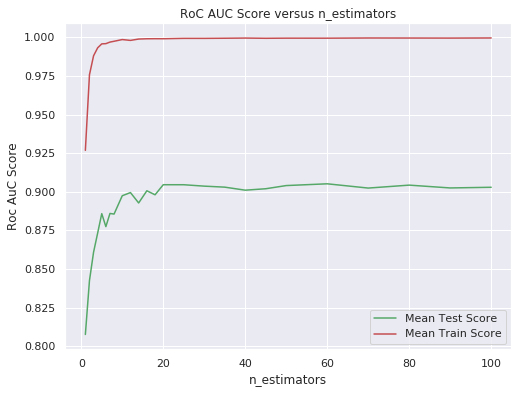

In [92]:
# n_estimators
rfc_2 = RandomForestClassifier()
n_estimators_list = [1, 2, 3, 4, 5, 6, 7] + list(range(8, 20, 2)) + list(range(20, 50, 5)) + list(range(50, 110, 10))
param_grid_2 = {'n_estimators': n_estimators_list}
rfc_search_1 = GridSearchCV(rfc_2, param_grid_2, cv=5, scoring='roc_auc', return_train_score=True)
rfc_search_1.fit(X_1, y_1)
rfc_results_1 = pd.DataFrame.from_dict(rfc_search_1.cv_results_)

# plot
sns.set(style='darkgrid', rc={'figure.figsize':(8, 6)})
fig17 = plt.figure(17)
ax1 = fig17.add_subplot(1, 1, 1)
l1, = ax1.plot(n_estimators_list, rfc_results_1.mean_test_score, 'g-')
l2, = ax1.plot(n_estimators_list, rfc_results_1.mean_train_score, 'r-')
ax1.set_title('RoC AUC Score versus n_estimators')
ax1.set_xlabel('n_estimators')
ax1.set_ylabel('Roc AuC Score')
plt.legend([l1, l2], ['Mean Test Score', 'Mean Train Score'])
plt.show()

In theory only some of what determines ones survival is contained in the datal; there are likely lurking variables. Dispite this the training score quickly approaches a value of one when it should not be able to do so (red curve). This is an overfitting problem. If we increase the number of trees in our forest too much the classifier increasingly fits noise. The overfitting starts when the testing curve fails to increase appreciably. We are looking for the 'turn' in the testing curve. This occurs at 14 trees, after that the testing score plateaus. 

A tree in our classifier will keep expanding until all of its leaves contain a number of samples less than or equal to 'min samples_split', which by defualt is two. We may want to keep the trees shorter as a measure against overfitting. The depth of the trees are determined with the hyperparameter 'max_depth'.

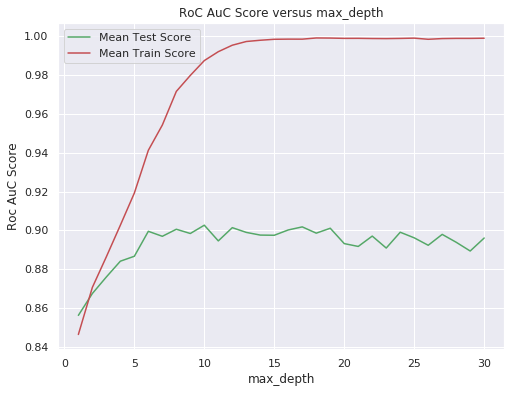

In [93]:
# max_depth
rfc_3 = RandomForestClassifier(n_estimators=14)
max_depth_list = np.linspace(1, 30, 30)
param_grid_3 = {'max_depth': max_depth_list}
rfc_search_2 = GridSearchCV(rfc_3, param_grid_3, cv=5, scoring='roc_auc', return_train_score=True)
rfc_search_2.fit(X_1, y_1)
rfc_results_2 = pd.DataFrame.from_dict(rfc_search_2.cv_results_)

# plot
fig18 = plt.figure(18)
ax1 = fig18.add_subplot(1, 1, 1)
l1, = ax1.plot(max_depth_list, rfc_results_2.mean_test_score, 'g-')
l2, = ax1.plot(max_depth_list, rfc_results_2.mean_train_score, 'r-')
ax1.set_title('RoC AuC Score versus max_depth')
ax1.set_xlabel('max_depth')
ax1.set_ylabel('Roc AuC Score')
plt.legend([l1, l2], ['Mean Test Score', 'Mean Train Score'])
plt.show()

The turn in the testing curve occurs at a max depth of 6. This limits the decision tree to 6 decisions but the testing curve indicates it does not need anymore. 

The minimum number of samples required to split a node in the tree is given by min_samples_split. Many of random forest's hyperparamters are interrelatred. As discussed before min_samples_split impacts the preformance of a varying max_depth, and the preformance of varying min_samples_split is impacted by max_depth. A grid search over all the hyperparamerts with 'GridSearchCV' will likely yield an overfit model as its selection criteria is the best mean test score. Tuning the hyperparamters individually is a good option as long as we are aware of those relationships.

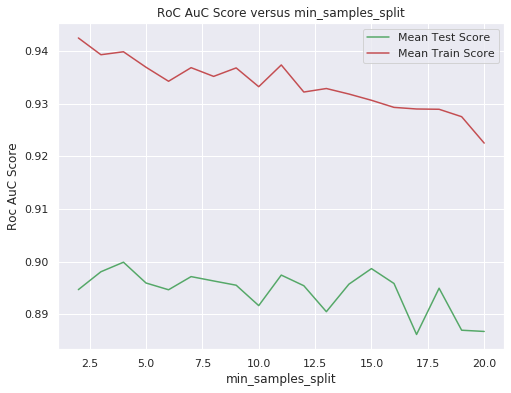

In [95]:
# min_samples_split
rfc_4 = RandomForestClassifier(n_estimators=14, max_depth=6)
min_samples_split = np.linspace(2, 20, 19, dtype=int)
param_grid_4 = {'min_samples_split': min_samples_split}
rfc_search_3 = GridSearchCV(rfc_4, param_grid_4, cv=5, scoring='roc_auc', return_train_score=True)
rfc_search_3.fit(X_1, y_1)
rfc_results_3 = pd.DataFrame.from_dict(rfc_search_3.cv_results_)

#plot
fig19 = plt.figure(19)
ax1 = fig19.add_subplot(1, 1, 1)
l1, = ax1.plot(min_samples_split, rfc_results_3.mean_test_score, 'g-')
l2, = ax1.plot(min_samples_split, rfc_results_3.mean_train_score, 'r-')
ax1.set_title('RoC AuC Score versus min_samples_split')
ax1.set_xlabel('min_samples_split')
ax1.set_ylabel('Roc AuC Score')
plt.legend([l1, l2], ['Mean Test Score', 'Mean Train Score'])
plt.show()

Both curves exhibit an overall decreasing trend with high variability. This suggests there is no reason to raise min_samples_split above its default value of two.

The hyperparameter 'min_samples_leaf' determines the minimum allowed samples in any leaf. Thus a node will permit a split only if both new branches will have at least min_samples_leaf samples. It has a default value of one.

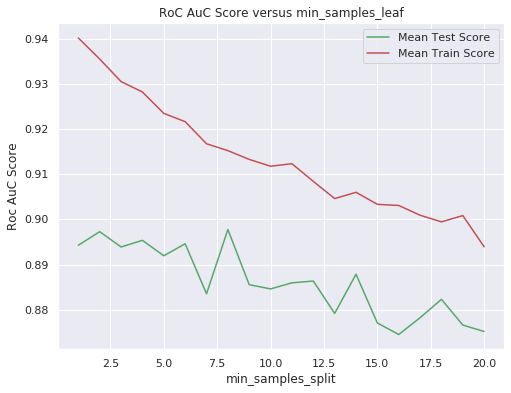

In [97]:
# min_samples_leaf
rfc_5 = RandomForestClassifier(n_estimators=14, max_depth=6, min_samples_split=2)
min_samples_leaf_list = np.linspace(1, 20, 20, dtype=int)
param_grid_5 = {'min_samples_leaf': min_samples_leaf_list}
rfc_search_4 = GridSearchCV(rfc_5, param_grid_5, cv=5, scoring='roc_auc', return_train_score=True)
rfc_search_4.fit(X_1, y_1)
rfc_results_4 = pd.DataFrame.from_dict(rfc_search_4.cv_results_)

# plot
fig20 = plt.figure(20)
ax1 = fig20.add_subplot(1, 1, 1)
l1, = ax1.plot(min_samples_leaf_list, rfc_results_4.mean_test_score, 'g-')
l2, = ax1.plot(min_samples_leaf_list, rfc_results_4.mean_train_score, 'r-')
ax1.set_title('RoC AuC Score versus min_samples_leaf')
ax1.set_xlabel('min_samples_split')
ax1.set_ylabel('Roc AuC Score')
plt.legend([l1, l2], ['Mean Test Score', 'Mean Train Score'])
plt.show()

Restrcting the minimum number of samples a leaf can have has a negative effect on our model's ability to classify the samples and should be left on one.

The last hyperparameter we will consider is max_features. This sets an upper limit for the maxmimum number of features that can be considered at once for a given split. In many instances the best split should only consider one or two features, such as is the case with the 'WCG' feature. If a sample is a member of a women child group we can determine their fate immediately with this feature alone. It is not the intention of this project to manually craft a descision tree classifier altough others have done this for the titanic data to great success. Since we have a few features such as 'WCG' and gender which are so powerful it may be useful the limit max_features.

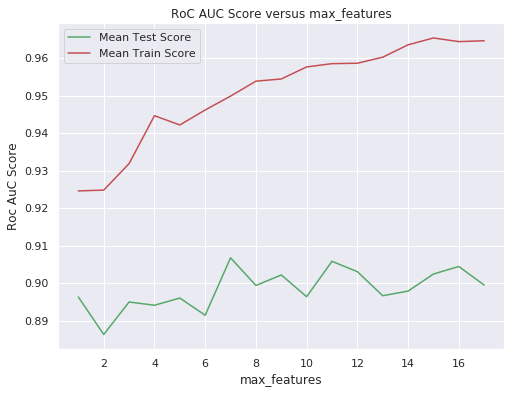

In [98]:
# max_features
rfc_6 = RandomForestClassifier(n_estimators=14, max_depth=6, min_samples_split=2, min_samples_leaf=1)
max_features_list = np.linspace(1, 17, 17, dtype=int)
param_grid_6 = {'max_features': max_features_list}
rfc_search_5 = GridSearchCV(rfc_6, param_grid_6, cv=5, scoring='roc_auc', return_train_score=True)
rfc_search_5.fit(X_1, y_1)
rfc_results_5 = pd.DataFrame.from_dict(rfc_search_5.cv_results_)

fig21 = plt.figure(21)
ax1 = fig21.add_subplot(1, 1, 1)
l1, = ax1.plot(max_features_list, rfc_results_5.mean_test_score, 'g-')
l2, = ax1.plot(max_features_list, rfc_results_5.mean_train_score, 'r-')
ax1.set_title('RoC AUC Score versus max_features')
ax1.set_xlabel('max_features')
ax1.set_ylabel('Roc AuC Score')
plt.legend([l1, l2], ['Mean Test Score', 'Mean Train Score'])
plt.show()

As anticipated some descisions could be being made with two many features in consideration. This is why the training score continues to increase while the testing score becomes volitile and plateaus. A 'max_feature' value of seven will be the most appropriate.

## Conclusion

We have our final model.

In [100]:
rfc_final = RandomForestClassifier(n_estimators=14, max_depth=6, min_samples_split=2, min_samples_leaf=1, max_features=7)
rfc_final_best_score = max(cross_val_score(rfc_final, X_1, y_1, cv=5, scoring='roc_auc'))
print(rfc_final_best_score)

0.944077172153265


With an RoC AuC of 0.944 our model predicts the training set very accurately. But does it generalise? What remains is to transform the test set and submit our reults to Kraggle for the real validation of our model.

In [106]:
rfc_final.fit(X_1, y_1)
predictions = rfc_final.predict(ar_test_filled)
output_array = np.transpose([list(df_test_set.index), predictions])

file = open("results.csv", "w+")
file.write('PassengerId,Survived')
for i in output_array:
    [csv_1, cvs_2] = i
    file.write('\n{},{}'.format(csv_1, cvs_2))
file.close()